In [1]:
from PIL import Image, ImageFont, ImageDraw
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import json
from random import shuffle
import random
from rembg import remove
from transformers import OwlViTProcessor, OwlViTForObjectDetection, AutoProcessor
import itertools
import seaborn as sns

In [2]:
# settings
annotations_folder_path: str = "../../../Data/Annotations/"
images_folder_path: str = "../../../Data/shells/"
fixed_images_path: str = "../../../Data/Fixed_support/"

examples_path: str = "../../../Tex/fig/chapter3/shell_examples/"

# Defining some classes and values

In [3]:
NO_MATCH = 0
NAME_DOES_NOT_MATCH = 1
CORRECT = 2

class Annotation:
    def __init__(self, *, filename = "", width = 0, height = 0, x = 0, y = 0, name = "") -> None:
        self.filename = filename
        self.boxwidth = width
        self.boxheight = height
        self.x = x
        self.y = y
        self.name = name
    
    def IoU(self, x, y, w, h):
        x1 = max(self.x, x)
        y1 = max(self.y, y)
        x2 = min(self.x + self.boxwidth, x + w)
        y2 = min(self.y + self.boxheight, y + h)
        intersection = max(0, x2 - x1) * max(0, y2 - y1)
        union = self.boxwidth * self.boxheight + w * h - intersection
        return intersection / union
    
    def compare(self, x, y, w, h, name, iou_threshold=0.5) -> int:
        if self.IoU(x, y, w, h) < iou_threshold:
            return NO_MATCH
        if self.name != name:
            return NAME_DOES_NOT_MATCH
        return CORRECT
    
    __repr__ = __str__ = lambda self: f"{self.filename} {self.boxwidth} {self.boxheight} {self.x} {self.y} {self.name}"

class AnnotatedImage:
    def __init__(self, *, img_dir = "", filename = "", annotations = []) -> None:
        if not filename:
            raise ValueError("filename cannot be empty")
        if not os.path.exists(os.path.join(img_dir, filename)):
            raise FileNotFoundError(f"image file {filename} not found in {img_dir}")
        self.filename = filename
        self.image = Image.open(os.path.join(img_dir, filename))
        self.annotations:list[Annotation] = annotations
    
    @property
    def width(self) -> int:
        return self.image.width
    
    @property
    def height(self) -> int:
        return self.image.height
    
    @staticmethod
    def from_xml(xml_file:str, img_dir = "") -> 'AnnotatedImage':
        tree = ET.parse(xml_file)
        root = tree.getroot()
        filename = root.find('filename').text
        annotations = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            x = int(obj.find('bndbox').find('xmin').text)
            y = int(obj.find('bndbox').find('ymin').text)
            boxwidth = int(obj.find('bndbox').find('xmax').text) - x
            boxheight = int(obj.find('bndbox').find('ymax').text) - y
            annotations.append(Annotation(filename = filename, width = boxwidth, height = boxheight, x = x, y = y, name = name))
        return AnnotatedImage(filename = filename, img_dir = img_dir, annotations = annotations)
    
    def get_object_image_cutout(self, annotation:Annotation) -> Image.Image:
        return self.image.crop((annotation.x, annotation.y, annotation.x + annotation.boxwidth, annotation.y + annotation.boxheight))
    
    @property
    def annotation_classes(self) -> list[str]:
        return [annotation.name for annotation in self.annotations]
    
    @property
    def object_image_cutouts(self) -> list[Image.Image]:
        return [self.get_object_image_cutout(annotation) for annotation in self.annotations]
    
    @property
    def objects(self) -> list[tuple[str, Image.Image]]:
        return list(zip(self.annotation_classes, self.object_image_cutouts))
    
    __str__ = lambda self: f"{self.filename} {self.width} {self.height} {self.annotations}"
    
    def check_annotation(self, annotation:Annotation) -> bool:
        return annotation in self.annotations
    
    def check_bbox(self, x, y, w, h, name) -> tuple[int, Annotation]:
        results = []
        for annotation in self.annotations:
            results.append((annotation.compare(x, y, w, h, name), annotation))
        values = [result[0] for result in results]
        max_value = max(values)
        max_value_index = values.index(max_value)
        return max_value, results[max_value_index][1]
    
    
USE_TEXT = 0
USE_RANDOM_IMAGE = 1
USE_PICKED_IMAGE = 2

# loading the dataset

In [4]:
dir, dirs, files = next(os.walk(annotations_folder_path))

annotated_images:list[AnnotatedImage] = []

for file in files:
    annotated_images.append(AnnotatedImage.from_xml(annotations_folder_path + file, images_folder_path))

#find the largest bounding box in the dataset 
max_width:int = 0
max_height:int = 0
for annotated_image in annotated_images:
    for annotation in annotated_image.annotations:
        if annotation.boxwidth * annotation.boxheight > max_width * max_height:
            max_width = annotation.boxwidth
            max_height = annotation.boxheight
            
print(max_width, max_height, max_width * max_height)

2780 1807 5023460


## Dataset statistics

annotations: {
    "Baltic tellin": 69,
    "Cockle": 89,
    "Thick trough shell": 91,
    "Mussel": 268,
    "Banded wedge shell": 32,
    "Elliptical trough shell": 18,
    "Cut trough shell": 36,
    "Oyster": 9,
    "Jackknife": 2
}
Total images: 96
Total annotations: 614
Total images: 302
Total un-annotated images: 206
[27872, 30444, 31304, 34320, 35175, 35905, 38804, 39130, 39501, 39775, 40600, 41925, 43240, 43780, 45024, 45264, 45901, 46315, 46795, 50232, 54516, 55000, 56430, 56964, 57566, 59598, 60753, 62244, 63832, 63948, 64965, 66389, 67797, 67800, 67854, 68272, 69560, 69936, 70272, 71441, 72452, 72772, 74635, 74740, 75472, 77400, 77720, 77843, 77910, 78030, 78108, 78616, 78765, 78948, 79460, 79534, 80073, 80586, 82650, 82663, 84280, 84364, 86460, 86584, 87579, 87750, 87912, 89040, 89376, 93532, 94428, 94752, 95718, 96280, 96570, 96824, 97526, 99400, 99550, 100536, 100540, 101210, 101518, 101518, 101654, 102074, 102660, 103020, 103212, 103734, 103740, 103944, 104110, 104646,

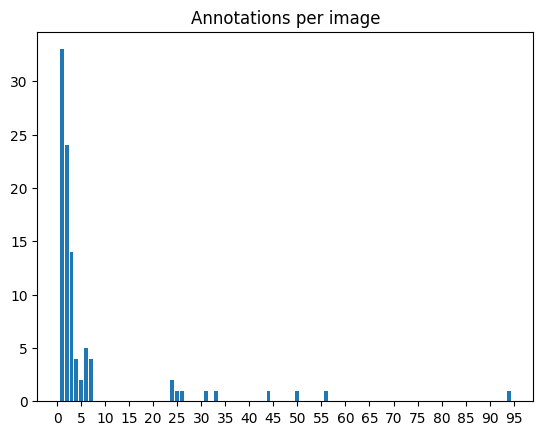

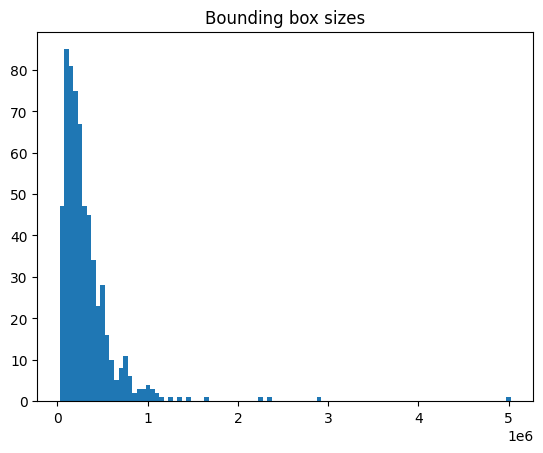

In [5]:
classes_count: dict[str, int] = {}

for img in annotated_images:
    for annotation in img.annotations:
        if annotation.name in classes_count:
            classes_count[annotation.name] += 1
        else:
            classes_count[annotation.name] = 1
            
print("annotations:", json.dumps(classes_count, indent=4))

print(f"Total images: {len(annotated_images)}")
print(f"Total annotations: {sum(classes_count.values())}")

# find the total un-anotated images
dir, dirs, files = next(os.walk(images_folder_path))
print(f"Total images: {len(files)}")
print(f"Total un-annotated images: {len(files) - len(annotated_images)}")

annotations_per_image_count = {}
for img in annotated_images:
    if len(img.annotations) in annotations_per_image_count:
        annotations_per_image_count[len(img.annotations)] += 1
    else:
        annotations_per_image_count[len(img.annotations)] = 1
# sort the dictionary by key
annotations_per_image_count = dict(sorted(annotations_per_image_count.items()))

# draw a graph of the annotations per image with as title "Annotations per image"
plt.bar(annotations_per_image_count.keys(), annotations_per_image_count.values())
plt.title("Annotations per image")
#more lines on the x-axis
plt.xticks(np.arange(0, max(annotations_per_image_count.keys()) + 5, 5.0))

# draw a bell curve of the size of the bounding boxes
# first get the sizes of the bounding boxes
sizes = []
for img in annotated_images:
    for annotation in img.annotations:
        sizes.append(annotation.boxwidth * annotation.boxheight)
# sort the sizes
sizes.sort()
print(sizes)
# average and median size
print(f"Average size: {sum(sizes) / len(sizes)}")
print(f"Average compare to total image size: {((sum(sizes) / len(sizes)) / (img.width * img.height))*100}%")
print(f"Median size: {sizes[len(sizes) // 2]}")
# draw the bell curve
plt.figure()
plt.hist(sizes, bins=100)
plt.title("Bounding box sizes")


# write 9 examples of images with annotations to a file (1.jpg => 9.jpg)
img_indexes = [1,5,20,54,92,52,15,65,75]
for i in range(9):
    annotated_image = annotated_images[img_indexes[i]]
    img = annotated_image.image.copy()
    draw = ImageDraw.Draw(img)
    for annotation in annotated_image.annotations:
        draw.rectangle((annotation.x, annotation.y, annotation.x + annotation.boxwidth, annotation.y + annotation.boxheight), outline="red", width=30)
    draw.text((10, 10), annotated_image.filename, fill="red", font=ImageFont.truetype("arial.ttf", 150))
    # resize the image by 10 times
    img = img.resize((int(img.width / 10), int(img.height / 10)))
    img.save(examples_path + str(i + 1) + ".jpg")

## Preparing the model

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")
    
processor:OwlViTProcessor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

Using GPU


## Data loading

In [7]:
# mode = USE_TEXT
mode = USE_RANDOM_IMAGE
# mode = USE_PICKED_IMAGE

remove_bg = False

#clone all img into test list
query_images = annotated_images.copy()

if mode == USE_TEXT:
    raise NotImplementedError("I should implement this")

elif mode == USE_RANDOM_IMAGE:
    # find an image for each class and extract it
    support_images = set()
    support_images_cutouts = {}
    for class_name in classes_count:
        for img in annotated_images:
            for annotation in img.annotations:
                if annotation.name == class_name:
                    support_images_cutouts[class_name] = img.get_object_image_cutout(annotation)
                    support_images.add(img)
                    break
            if class_name in support_images_cutouts:
                break

    for img in support_images:
        query_images.remove(img)
        
elif mode == USE_PICKED_IMAGE:
    support_images_cutouts = {}
    imgs = list(os.walk(fixed_images_path + "base"))[0][2]
    for img in imgs:
        print(f"loading {img}")
        shell_name = img.split(".")[0]
        image = Image.open(fixed_images_path + "base/" + img)
        support_images_cutouts[shell_name] = image

else:
    raise NotImplementedError("Mode not set")

orig_imgs = support_images_cutouts.copy()

<PIL.Image.Image image mode=RGB size=300x258 at 0x2580C435940>
<PIL.Image.Image image mode=RGB size=295x253 at 0x2580C4359A0>
<PIL.Image.Image image mode=RGB size=182x172 at 0x2580C4358B0>
<PIL.Image.Image image mode=RGB size=371x532 at 0x2580C435790>
<PIL.Image.Image image mode=RGB size=398x372 at 0x2580C435700>
<PIL.Image.Image image mode=RGB size=473x338 at 0x2580C4356D0>
<PIL.Image.Image image mode=RGB size=365x328 at 0x2580C4356A0>
<PIL.Image.Image image mode=RGB size=597x483 at 0x2580C435670>
<PIL.Image.Image image mode=RGB size=1045x2170 at 0x2580C4355E0>
{'Baltic tellin': <PIL.Image.Image image mode=RGB size=300x258 at 0x2580C435940>, 'Cockle': <PIL.Image.Image image mode=RGB size=295x253 at 0x2580C4359A0>, 'Thick trough shell': <PIL.Image.Image image mode=RGB size=182x172 at 0x2580C4358B0>, 'Mussel': <PIL.Image.Image image mode=RGB size=371x532 at 0x2580C435790>, 'Banded wedge shell': <PIL.Image.Image image mode=RGB size=398x372 at 0x2580C435700>, 'Elliptical trough shell': <P

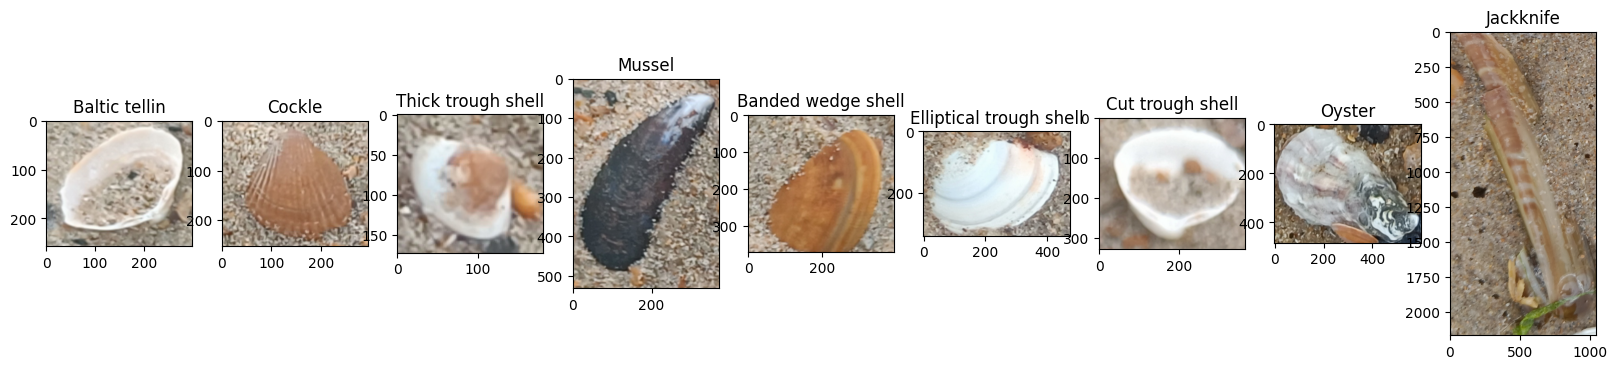

In [8]:
support_images_cutouts = orig_imgs.copy()

if remove_bg and (mode == USE_PICKED_IMAGE or mode == USE_RANDOM_IMAGE):
    # loop over all support images and remove background
    for class_name, img in support_images_cutouts.items():
        print(f"removing background from {class_name}")
        img_copy = img.copy()
        img_copy = remove(img_copy, bgcolor=(0, 0, 0, 0)).convert("RGB")
        support_images_cutouts[class_name] = img_copy
        
if mode == USE_PICKED_IMAGE or mode == USE_RANDOM_IMAGE:
    # show original images
    plt.figure(figsize=(20, 20))
    for i, (class_name, img) in enumerate(orig_imgs.items()):
        plt.subplot(1, len(orig_imgs), i + 1)
        plt.title(class_name)
        plt.imshow(img)
        print(img)
    if remove_bg:
        # show cutout images
        plt.figure(figsize=(20, 20))
        for i, (class_name, img) in enumerate(support_images_cutouts.items()):
            plt.subplot(1, len(support_images_cutouts), i + 1)
            plt.title(class_name)
            plt.imshow(img)
            print(img)
    
print(support_images_cutouts)
print(orig_imgs)

In [9]:
model = model.to(device)
model.eval()

outputs_list = []


vals = list(orig_imgs.values())

for q in range(len(query_images)):
    print(f"Query image {q}")

    test_image_annotated = query_images[q]

    test_image = test_image_annotated.image

    test_image_filename = test_image_annotated.filename

    inputs = processor(query_images=vals, images=test_image, return_tensors="pt").to(device)
    for key, val in inputs.items():
        print(f"{key}: {val.shape}")
    
    with torch.no_grad():
        outputs = model.image_guided_detection(**inputs)
    outputs.logits = outputs.logits.cpu()
    outputs.target_pred_boxes = outputs.target_pred_boxes.cpu()
    outputs.pred_boxes = outputs.target_pred_boxes.cpu()
    outputs_list.append(outputs)
    
# remove the model to free up memory
torch.cuda.empty_cache()


Query image 0
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 1
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 2
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 3
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 4
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 5
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 6
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 7
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 8
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 9
query_pixel_values: torch.Size([

In [10]:
visual: bool = False
stats: bool = False
verbose: int = 2

do_nmss: list[bool] = [True, False]
iou_thresholds: list[float] = [i / 10 for i in range(0, 11)]
score_thresholds: list[float] = [i / 100 for i in range(0, 101)]
filter_too_big_options: list[bool] = [True, False]

resultfile = open("results.csv", "w")
resultfile.write("do_nms,iou_threshold,score_threshold,filter_too_big,correct,correct_box,incorrect,undetected\n")

options_matrix = list(itertools.product(do_nmss, iou_thresholds, score_thresholds, filter_too_big_options))
print(f"Total number of options: {len(options_matrix)}")

def process_options(do_nms, iou_threshold, score_threshold, filter_too_big, outfile=None) -> tuple[int, int, int, int]:
    correct = 0
    wrong_class = 0
    wrong = 0
    undetected = 0
    for q in range(len(query_images)):
        test_image_annotated = query_images[q]
        test_image = test_image_annotated.image
        outputs = outputs_list[q]

        target_sizes = torch.Tensor([test_image.size[::-1]] * len(vals))
        results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold = score_threshold)
        boxes, scores, labels = results[0]["boxes"], results[0]["scores"], results[0]["labels"]

        for i in range(1, len(support_images_cutouts.keys())):
            im_boxes, im_scores, im_labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
            boxes = torch.cat((boxes, im_boxes), dim=0)
            scores = torch.cat((scores, im_scores), dim=0)
            # add offset i to labels
            im_labels = im_labels + i
            labels = torch.cat((labels, im_labels), dim=0)
        
        if filter_too_big:
            # filter out boxes that have a height or width larger than the largest annotated box
            max_box_size = max([max([a.boxwidth, a.boxheight]) for a in test_image_annotated.annotations])
            keep = []
            for i, box in enumerate(boxes):
                if max(box[2]-box[0], box[3]-box[1]) < max_box_size:
                    keep.append(i)
            boxes = boxes[keep]
            scores = scores[keep]
            labels = labels[keep]

        # non-maximum suppression with torchvision
        if do_nms:
            keep = torchvision.ops.nms(boxes, scores, iou_threshold=iou_threshold)
            boxes = boxes[keep]
            scores = scores[keep]
            labels = labels[keep]

        boxes_in_image = set()
        for box, score, label in zip(boxes, scores, labels):
            box = [round(i, 2) for i in box.tolist()]
            if(verbose > 3): print(f"Detected {list(support_images_cutouts.keys())[label]} with confidence {round(score.item(), 3)} at location {box}")
            # check if box is in the annotated image (x;y;w;h;name)
            correctness, box = test_image_annotated.check_bbox(box[0], box[1], box[2]-box[0], box[3]-box[1], list(support_images_cutouts.keys())[label])
            boxes_in_image.add(box)
            if correctness == CORRECT:
                if(verbose > 3): print("Correct!")
                # correct aka true positive
                correct += 1
            elif correctness == NAME_DOES_NOT_MATCH:
                if(verbose > 3): print("Name does not match!")
                # wrong class is false positive
                wrong_class += 1
            elif correctness == NO_MATCH:
                if(verbose > 3): print("No match!")
                # wrong is false positive
                wrong += 1
            else:
                raise Exception("Unknown correctness value")
        # check if all annotated boxes are in the detected boxes
        for annotation in test_image_annotated.annotations:
            if annotation not in boxes_in_image:
                if(verbose > 3): print(f"Annotation {annotation} not found!")
                # wrong is false negative
                undetected += 1
        if(verbose>2): print(f"Correct: {correct}, Wrong class: {wrong_class}, Wrong: {wrong}")

        if(outfile is not None):
            # draw bounding boxes on image
            image = test_image.copy()
            draw = ImageDraw.Draw(image)
            for box, score, label in zip(boxes, scores, labels):
                box = [round(i, 2) for i in box.tolist()]
                if score >= score_threshold:
                    draw.rectangle(box, outline="red", width=10)
                    #add label and score
            draw.text((box[0]+10, box[1]+10), f"{list(support_images_cutouts.keys())[label]} {round(score.item(), 3)}", fill="red", font=ImageFont.truetype("arial", 120))

            image.save(f"out/unfiltered_{q}.jpg")
    return(correct, wrong_class, wrong, undetected)


Total number of options: 4444


In [ ]:
visual: bool = True
stats: bool = False
verbose: int = 2

do_nmss: list[bool] = [True, False]
iou_thresholds: list[float] = [0.9]
score_thresholds: list[float] = [0.2]
filter_too_big_options: list[bool] = [True, False]

options_matrix = list(itertools.product(do_nmss, iou_thresholds, score_thresholds, filter_too_big_options))

for do_nms, iou_threshold, score_threshold, filter_too_big in options_matrix:
    correctnesses:list[tuple[int, int, int]] = []
    for q in range(len(query_images)):
        test_image_annotated = query_images[q]
        test_image = test_image_annotated.image
        outputs = outputs_list[q]

        target_sizes = torch.Tensor([test_image.size[::-1]] * len(vals))
        results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold = score_threshold)
        boxes, scores, labels = results[0]["boxes"], results[0]["scores"], results[0]["labels"]

        for i in range(1, len(support_images_cutouts.keys())):
            im_boxes, im_scores, im_labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
            boxes = torch.cat((boxes, im_boxes), dim=0)
            scores = torch.cat((scores, im_scores), dim=0)
            # add offset i to labels
            im_labels = im_labels + i
            labels = torch.cat((labels, im_labels), dim=0)
        
        if filter_too_big:
            # filter out boxes that have a height or width larger than the largest annotated box
            max_box_size = max([max([a.boxwidth, a.boxheight]) for a in test_image_annotated.annotations])
            keep = []
            for i, box in enumerate(boxes):
                if max(box[2]-box[0], box[3]-box[1]) < max_box_size:
                    keep.append(i)
            boxes = boxes[keep]
            scores = scores[keep]
            labels = labels[keep]

        # non-maximum suppression with torchvision
        if do_nms:
            keep = torchvision.ops.nms(boxes, scores, iou_threshold=iou_threshold)
            boxes = boxes[keep]
            scores = scores[keep]
            labels = labels[keep]

        if stats:
            correct = 0
            wrong_class = 0
            wrong = 0
            for box, score, label in zip(boxes, scores, labels):
                box = [round(i, 2) for i in box.tolist()]
                if(verbose > 3): print(f"Detected {list(support_images_cutouts.keys())[label]} with confidence {round(score.item(), 3)} at location {box}")
                # check if box is in the annotated image (x;y;w;h;name)
                correctness = test_image_annotated.check_bbox(box[0], box[1], box[2]-box[0], box[3]-box[1], list(support_images_cutouts.keys())[label])
                if correctness == CORRECT:
                    if(verbose > 3): print("Correct!")
                    correct += 1
                elif correctness == NAME_DOES_NOT_MATCH:
                    if(verbose > 3): print("Name does not match!")
                    wrong_class += 1
                elif correctness == NO_MATCH:
                    if(verbose > 3): print("No match!")
                    wrong += 1
                else:
                    raise Exception("Unknown correctness value")
            if(verbose>2): print(f"Correct: {correct}, Wrong class: {wrong_class}, Wrong: {wrong}")
            correctnesses.append((correct, wrong_class, wrong))

        
        if visual:
            # draw bounding boxes on image
            image = test_image.copy()
            draw = ImageDraw.Draw(image)
            for box, score, label in zip(boxes, scores, labels):
                box = [round(i, 2) for i in box.tolist()]
                draw.rectangle(box, outline="red", width=10)
                #add label and score
                draw.text((box[0]+10, box[1]+10), f"{list(support_images_cutouts.keys())[label]} {round(score.item(), 3)}", fill="red", font=ImageFont.truetype("arial", 120))

            image.save(f"out/{'Filtered' if filter_too_big else 'Unfiltered'}_{'NMS' if do_nms else 'NO_NMS'}_{q}.jpg")
    if(stats):
        resultfile.write(f"{do_nms},{iou_threshold},{score_threshold},{filter_too_big},{sum([c[0] for c in correctnesses])},{sum([c[1] for c in correctnesses])},{sum([c[2] for c in correctnesses])}\n")
        print(f"Filter too big: {filter_too_big}")
        print(f"IOU threshold: {iou_threshold}")
        print(f"Score threshold: {score_threshold}")
        print(f"Correct: {sum([c[0] for c in correctnesses])}, Wrong class: {sum([c[1] for c in correctnesses])}, Wrong: {sum([c[2] for c in correctnesses])}")
        print(f"Accuracy: {round(100 * sum([c[0] for c in correctnesses])/sum([sum(c) for c in correctnesses]), 3)}%")
        print(f"Accuracy (correct bbox): {round(100 * (sum([c[0] for c in correctnesses])+sum([c[1] for c in correctnesses]))/sum([sum(c) for c in correctnesses]), 3)}%")


In [ ]:

counter = 0
for do_nms, iou_threshold, score_threshold, filter_too_big in options_matrix:
    print(f"Option {counter+1}/{len(options_matrix)}")
    counter += 1
    correctnesses:list[tuple[int, int, int, int]] = []
    correctness = process_options(do_nms, iou_threshold, score_threshold, filter_too_big)
    correctnesses.append(correctness)
    resultfile.write(f"{do_nms},{iou_threshold},{score_threshold},{filter_too_big},{sum([c[0] for c in correctnesses])},{sum([c[1] for c in correctnesses])},{sum([c[2] for c in correctnesses])},{sum([c[3] for c in correctnesses])}\n")
            
    if(stats):
        print(f"Filter too big: {filter_too_big}")
        print(f"IOU threshold: {iou_threshold}")
        print(f"Score threshold: {score_threshold}")
        print(f"Correct: {sum([c[0] for c in correctnesses])}, Wrong class: {sum([c[1] for c in correctnesses])}, Wrong: {sum([c[2] for c in correctnesses])}")
        print(f"Accuracy: {round(100 * sum([c[0] for c in correctnesses])/sum([sum(c) for c in correctnesses]), 3)}%")
        print(f"Accuracy (correct bbox): {round(100 * (sum([c[0] for c in correctnesses])+sum([c[1] for c in correctnesses]))/sum([sum(c) for c in correctnesses]), 3)}%")


resultfile.close()

In [11]:
df = pd.read_csv("results_4444.csv")
df.head()

df["true positive"] = df["correct"]
df["false positive"] = df["incorrect"] + df["correct_box"]
df["false negative"] = df["undetected"]
# remove correct, incorrect, correct_box, undetected
df.drop(columns=["correct", "incorrect", "undetected"], inplace=True)
df["Precision"] = round(100 * (df["true positive"]/(df["true positive"] + df["false positive"])), 3)
df["Precision (correct bbox)"] = round(100 * (df["true positive"] + df["correct_box"])/(df["true positive"] + df["false positive"]), 3)
df["Recall"] = round(100 * (df["true positive"]/(df["true positive"] + df["false negative"])), 3)
df["Recall (correct bbox)"] = round(100 * (df["true positive"] + df["correct_box"])/(df["true positive"] + df["false negative"]), 3)
df["F1"] = round(2 * df["Precision"] * df["Recall"]/(df["Precision"] + df["Recall"]), 3)

df.to_csv("results_processed.csv", index=True)


Text(0.5, 0.98, '')

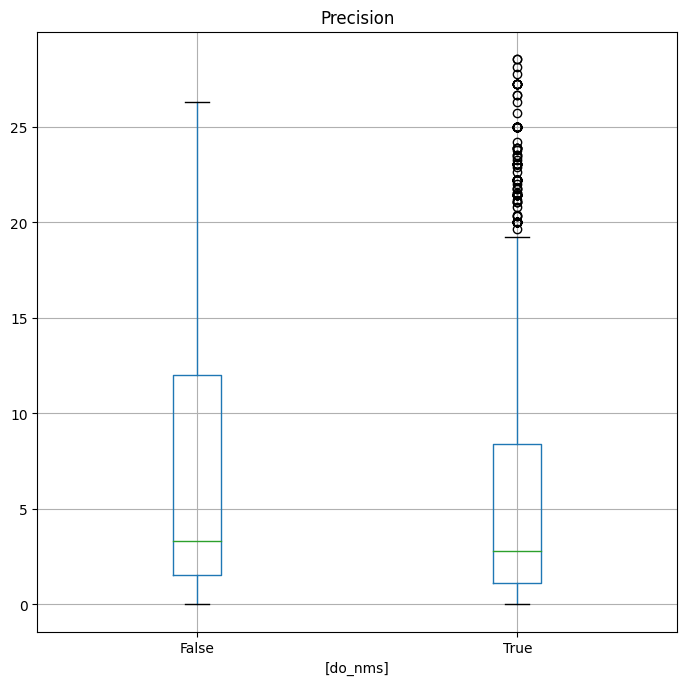

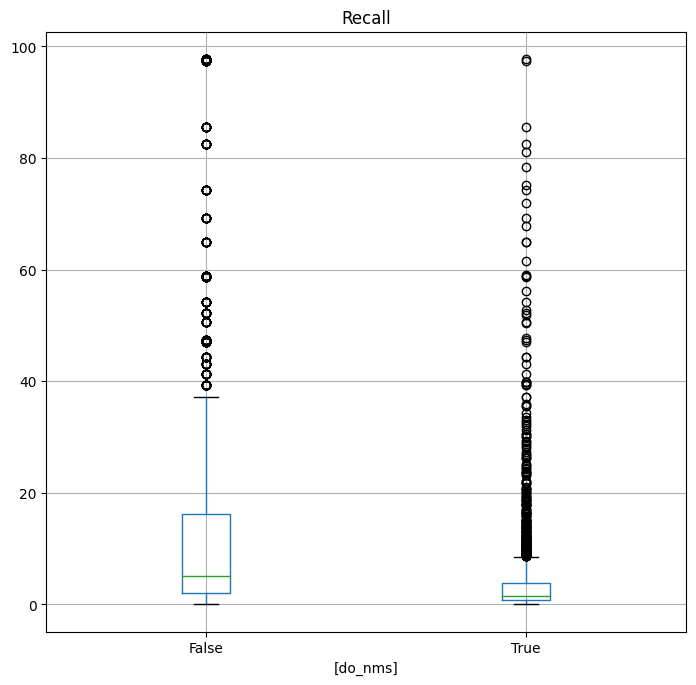

In [68]:
df_no_nms = df[df["do_nms"] == False]
df_nms = df[df["do_nms"] == True]

# boxplot of precision with nms True vs False
nms_precision_graph = df.boxplot(column=["Precision"], by=["do_nms"], figsize=(8, 8))
plt.suptitle("")


# boxplot of recall with nms True vs False
nms_recall_graph = df.boxplot(column=["Recall"], by=["do_nms"], figsize=(8, 8))
plt.suptitle("")


Text(0.5, 1.0, 'Max precision and recall with different IOU thresholds for NMS')

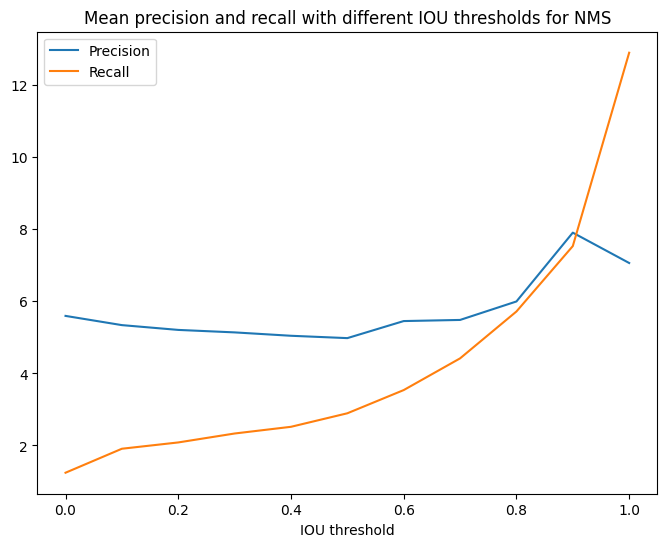

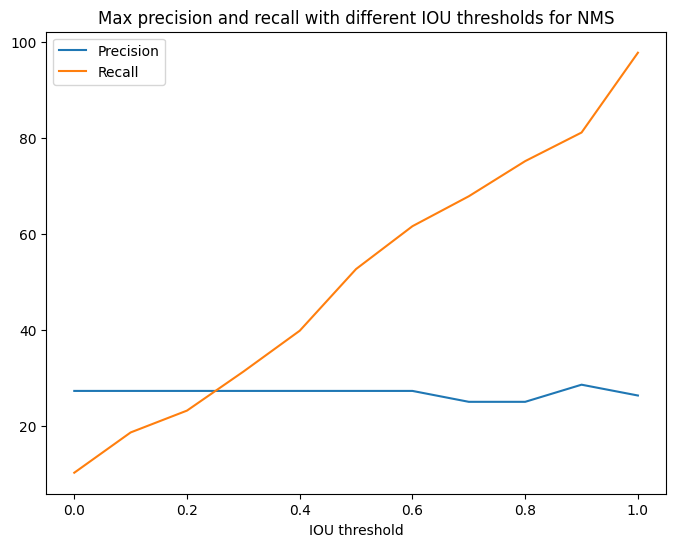

In [62]:
# precision and recall with different iou_thresholds in a line plot on two axes for nms (as iou_threshold is not used without nms)
df_nms.groupby("iou_threshold").mean().plot(y=["Precision", "Recall"], figsize=(8, 6))
plt.xlabel("IOU threshold")
plt.suptitle("")
plt.title("Mean precision and recall with different IOU thresholds for NMS")

# max precision and recall with different iou_thresholds in a line plot on two axes for nms (as iou_threshold is not used without nms)
df_nms.groupby("iou_threshold").max().plot(y=["Precision", "Recall"], figsize=(8, 6))
plt.xlabel("IOU threshold")
plt.suptitle("")
plt.title("Max precision and recall with different IOU thresholds for NMS")

<AxesSubplot:xlabel='score_threshold'>

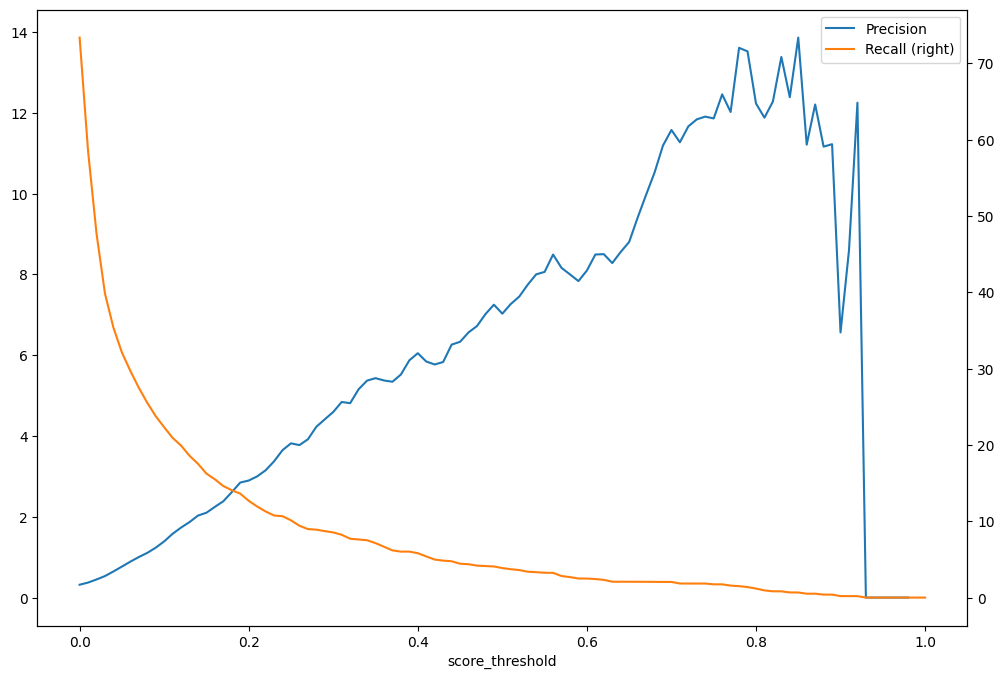

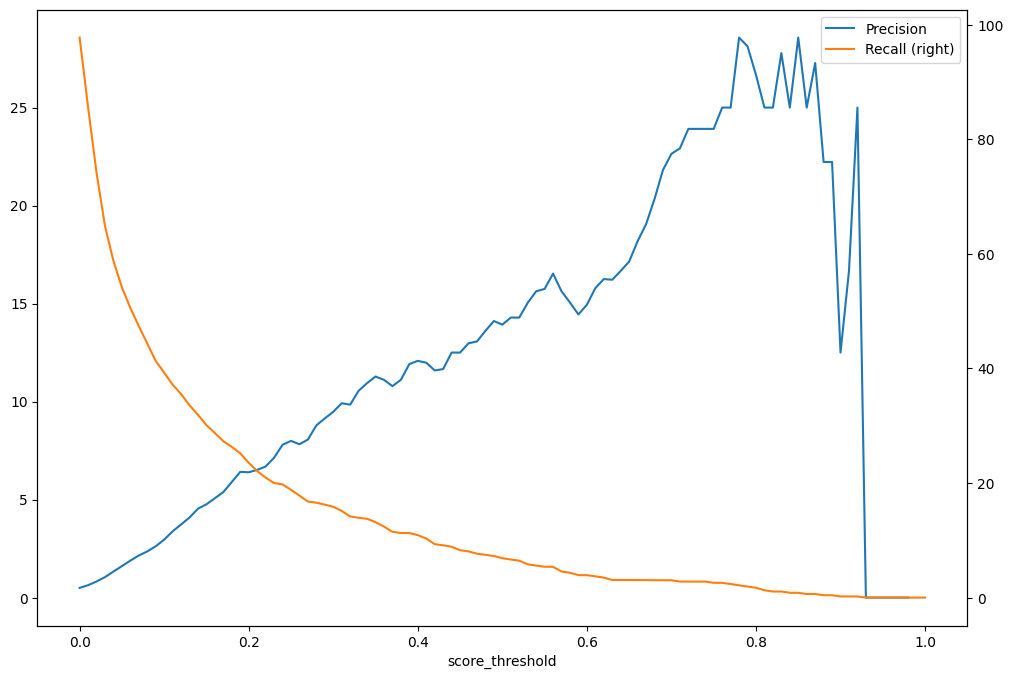

In [67]:
# precision and recall with different score_thresholds in a line plot on two axes
df.groupby(["score_threshold"]).mean().plot(y=["Precision", "Recall"], figsize=(12, 8), secondary_y="Recall")

df.groupby(["score_threshold"]).max().plot(y=["Precision", "Recall"], figsize=(12, 8), secondary_y="Recall")

Text(0.5, 0.98, '')

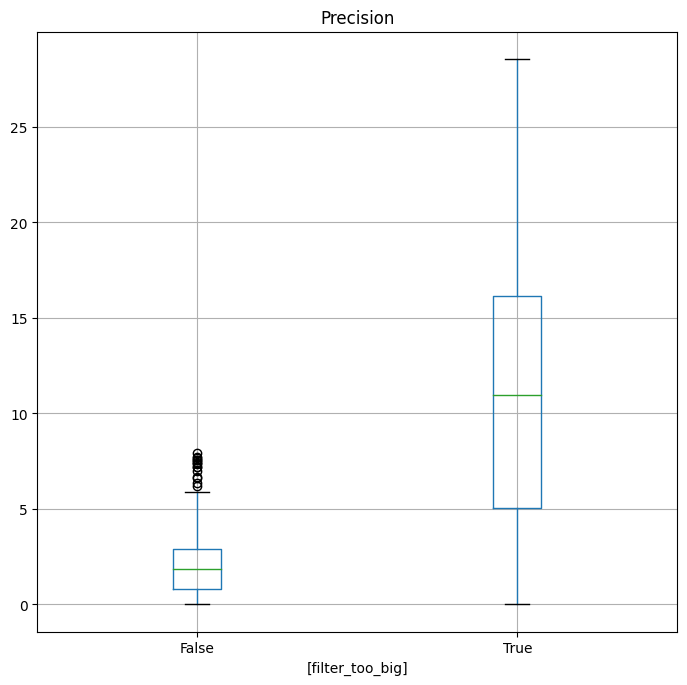

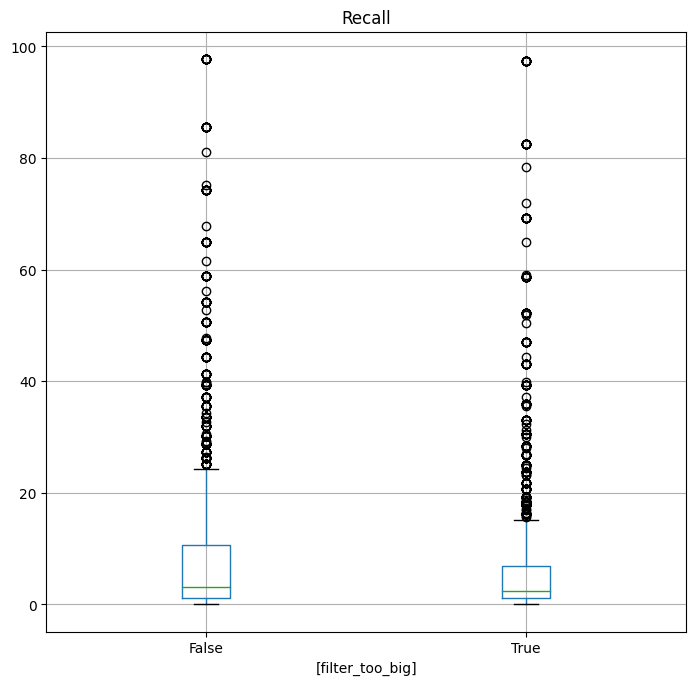

In [66]:
# boxplot of precision with filter_too_big True vs False
df.boxplot(column=["Precision"], by=["filter_too_big"], figsize=(8, 8))
plt.suptitle("")

# boxplot of recall with filter_too_big True vs False
df.boxplot(column=["Recall"], by=["filter_too_big"], figsize=(8, 8))
plt.suptitle("")

Maximum precision: 28.571, with params: 
do_nms: True
iou_threshold: 0.9
score_threshold: 0.78
filter_too_big: True

Maximum recall: 97.781, with params: 
do_nms: True
iou_threshold: 1.0
score_threshold: 0.0
filter_too_big: False

mAP: 4.673%


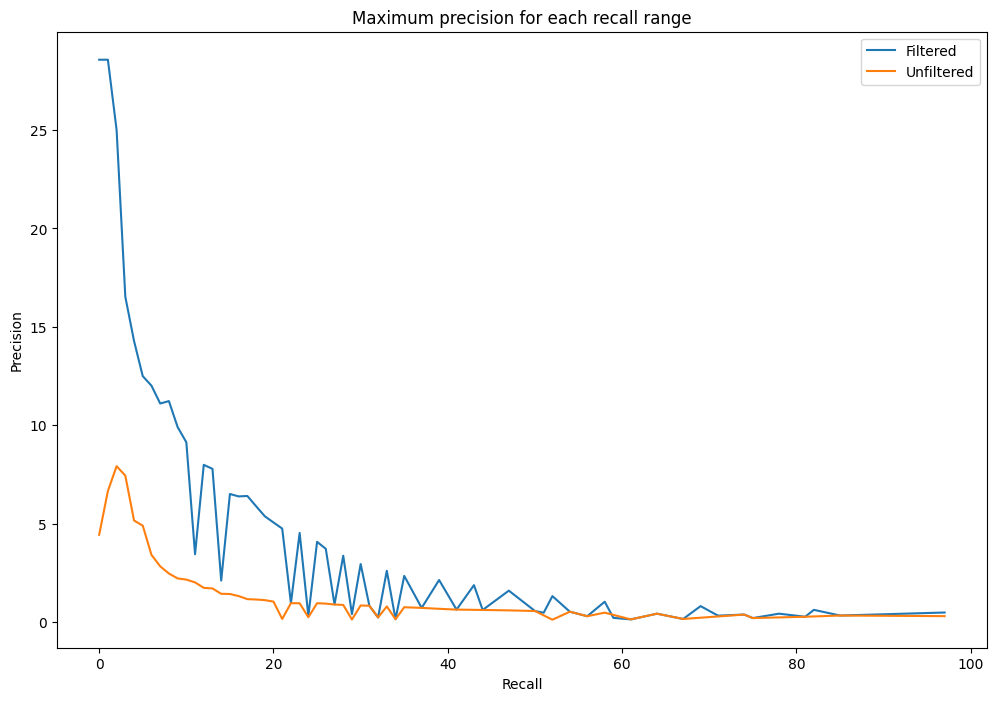

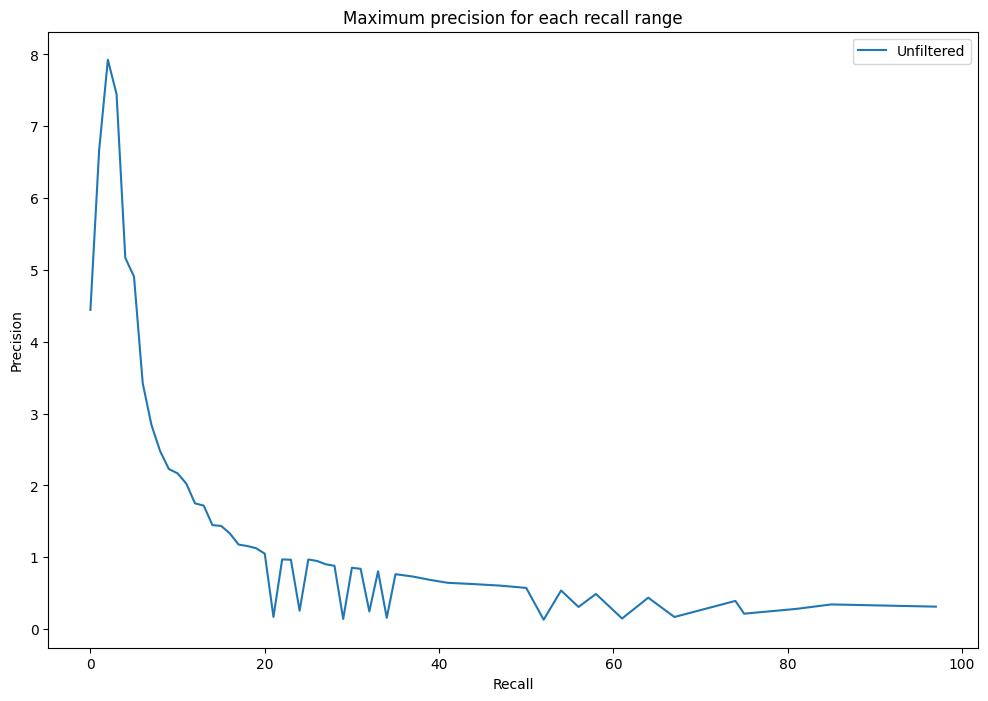

In [69]:
# top row only
maxpre = df[df["Precision"] == df["Precision"].max()].head(1)
print(f"Maximum precision: {maxpre['Precision'].values[0]}, with params: \ndo_nms: {maxpre['do_nms'].values[0]}\niou_threshold: {maxpre['iou_threshold'].values[0]}\nscore_threshold: {maxpre['score_threshold'].values[0]}\nfilter_too_big: {maxpre['filter_too_big'].values[0]}\n")

# maximum recall
df[df["Recall"] == df["Recall"].max()]
# top row only
maxrec = df[df["Recall"] == df["Recall"].max()].head(1)
print(f"Maximum recall: {maxrec['Recall'].values[0]}, with params: \ndo_nms: {maxrec['do_nms'].values[0]}\niou_threshold: {maxrec['iou_threshold'].values[0]}\nscore_threshold: {maxrec['score_threshold'].values[0]}\nfilter_too_big: {maxrec['filter_too_big'].values[0]}\n")

df_test = df.copy()

# create a new column with the recall range (0-1, 1-2, etc.)
df_test["Recall Rounded"] = (df_test["Recall"]).astype(int)

# group the results by recall range and get the maximum precision for each group
max_precisions = df_test.groupby("Recall Rounded")["Precision"].max().reset_index()
# same, but only for the rows without filtering too big
max_precisions_filtered = df_test[df_test["filter_too_big"] == False].groupby("Recall Rounded")["Precision"].max().reset_index()

# plot the maximum precision for each recall range (filtered and unfiltered on the same plot)
plt.figure(figsize=(12, 8))
plt.plot(max_precisions["Recall Rounded"], max_precisions["Precision"], label="Filtered")
plt.plot(max_precisions_filtered["Recall Rounded"], max_precisions_filtered["Precision"], label="Unfiltered")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Maximum precision for each recall range")
plt.legend()


# mAP
mAP = round(max_precisions["Precision"].mean(), 3)
print(f"mAP: {mAP}%")


# same, but only for the rows without filtering too big
mAP_filtered = round(max_precisions_filtered["Precision"].mean(), 3)


In [73]:
for q in range(len(query_images)):
    print(f"Query image {q}")
    vals = list(orig_imgs.values())

    test_image_annotated = query_images[i]

    test_image = test_image_annotated.image

    test_image_filename = test_image_annotated.filename

    inputs = processor(query_images=vals, images=test_image, return_tensors="pt").to(device)
    for key, val in inputs.items():
        print(f"{key}: {val.shape}")
        
    outputs = model.image_guided_detection(**inputs)
    outputs.logits = outputs.logits.cpu()
    outputs.target_pred_boxes = outputs.target_pred_boxes.cpu()
    outputs.pred_boxes = outputs.target_pred_boxes.cpu()
    target_sizes = torch.Tensor([test_image.size[::-1]] * len(vals))
    score_threshold = 0.05
    results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold = score_threshold)
    boxes, scores, labels = results[0]["boxes"], results[0]["scores"], results[0]["labels"]

    for i in range(1, len(support_images_cutouts.keys())):
        im_boxes, im_scores, im_labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
        boxes = torch.cat((boxes, im_boxes), dim=0)
        scores = torch.cat((scores, im_scores), dim=0)
        # add offset i to labels
        im_labels = im_labels + i
        labels = torch.cat((labels, im_labels), dim=0)
        

    # non-maximum suppression with torchvision
    if True:
        keep = torchvision.ops.nms(boxes, scores, iou_threshold=0.5)
        boxes = boxes[keep]
        scores = scores[keep]
        labels = labels[keep]

    for box, score, label in zip(boxes, scores, labels):
        box = [round(i, 2) for i in box.tolist()]
        if score >= score_threshold:
            print(f"Detected {list(support_images_cutouts.keys())[label]} with confidence {round(score.item(), 3)} at location {box}")
            
    # draw bounding boxes on image
    image = test_image.copy()
    draw = ImageDraw.Draw(image)
    for box, score, label in zip(boxes, scores, labels):
        box = [round(i, 2) for i in box.tolist()]
        if score >= score_threshold:
            draw.rectangle(box, outline="red", width=10)
            #add label and score
            draw.text((box[0]+10, box[1]+10), f"{list(support_images_cutouts.keys())[label]} {round(score.item(), 3)}", fill="red", font=ImageFont.truetype("arial", 120))

    image.save(f"out/unfiltered_{q}.jpg")

Query image 0
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])


OutOfMemoryError: CUDA out of memory. Tried to allocate 62.00 MiB (GPU 0; 8.00 GiB total capacity; 7.09 GiB already allocated; 0 bytes free; 7.27 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [23]:
# this is redundant now that we calculated more combinations above

"""
use process_options(do_nms, iou_threshold, score_threshold, filter_too_big) -> tuple[int, int, int, int]: with the settings above, but running an array of options for score_threshold to plot a precision-recall curve
score_thresholds_filtered = np.arange(0.01, 1.0, 0.01)
results_filtered:list[tuple[int, int, int, int]] = []
for score_threshold in score_thresholds_filtered:
    results = process_options(do_nms_filtered, iou_threshold_filtered, score_threshold, filter_too_big_filtered)
    correct = results[0]
    correct_bbox = results[1]
    incorrect = results[2]
    missing = results[3]
    results_filtered.append((correct, correct_bbox, incorrect, missing))

score_thresholds = np.arange(0.01, 1.0, 0.01)
results_pure:list[tuple[int, int, int, int]] = []
for score_threshold in score_thresholds:
    results = process_options(do_nms, iou_threshold, score_threshold, filter_too_big)
    results_pure.append(results)


print(results_filtered)
print(results_pure)

precision_recall_pairs_filtered = []
for r in results_filtered:
    tp = r[0]
    fp = r[1] + r[2]
    fn = r[3]
    precision = tp/(tp+fp) if tp+fp > 0 else 0
    recall = tp/(tp+fn) if tp+fn > 0 else 0
    if(precision > 0 and recall > 0):
        precision_recall_pairs_filtered.append((precision, recall))

print(precision_recall_pairs_filtered)

precision_recall_pairs = []
for r in results_pure:
    tp = r[0]
    fp = r[1] + r[2]
    fn = r[3]
    precision = tp/(tp+fp) if tp+fp > 0 else 0
    recall = tp/(tp+fn) if tp+fn > 0 else 0
    if(precision > 0 and recall > 0):
        precision_recall_pairs.append((precision, recall))
print(precision_recall_pairs)

# plot precision-recall curve
plt.figure(figsize=(12, 8))
plt.plot([x[1] for x in precision_recall_pairs_filtered], [x[0] for x in precision_recall_pairs_filtered], label="filtered")
plt.plot([x[1] for x in precision_recall_pairs], [x[0] for x in precision_recall_pairs], label="pure")
"""

'\nuse process_options(do_nms, iou_threshold, score_threshold, filter_too_big) -> tuple[int, int, int, int]: with the settings above, but running an array of options for score_threshold to plot a precision-recall curve\nscore_thresholds_filtered = np.arange(0.01, 1.0, 0.01)\nresults_filtered:list[tuple[int, int, int, int]] = []\nfor score_threshold in score_thresholds_filtered:\n    results = process_options(do_nms_filtered, iou_threshold_filtered, score_threshold, filter_too_big_filtered)\n    correct = results[0]\n    correct_bbox = results[1]\n    incorrect = results[2]\n    missing = results[3]\n    results_filtered.append((correct, correct_bbox, incorrect, missing))\n\nscore_thresholds = np.arange(0.01, 1.0, 0.01)\nresults_pure:list[tuple[int, int, int, int]] = []\nfor score_threshold in score_thresholds:\n    results = process_options(do_nms, iou_threshold, score_threshold, filter_too_big)\n    results_pure.append(results)\n'